In [23]:
import numpy as np
from copy import deepcopy

In [24]:
def gen(n, m, max_w, k=None):
    
    if k > m:
        return None
    
    for _ in range(100):
        cost_matrix = np.random.randint(0, max_w + 1, (n, m))

        types = {}
        num_t = 0
        for i in range(m):
            type_ = tuple(cost_matrix[:, i])
            if type_ in types:
                types[type_] += 1
            else:
                types[type_] = 1
                num_t += 1

        if k:
            if num_t == k:
                return types
            elif num_t > k:
                inds = np.random.choice(np.arange(num_t), k, replace=False)
                inds = [list(types.keys())[i] for i in inds]
                sum_num = 0
                
                for i in inds:
                    sum_num += types[i]
                
                res_types = {i: types[i] for i in inds}
                addition = np.random.choice(np.arange(k), m - sum_num, replace=True)
                
                for i in addition:
                    res_types[inds[i]] += 1
            
                return res_types
            else:
                continue
        else:
            return types
    
    return None

In [25]:
def gen_2_diff_weights(n, m, max_w, k=None): # k in (2, 10), m in (2, 15)  m = 15, k = 3, max 125
    
    weights = np.random.choice(np.arange(max_w + 1), k, replace=False)
    
    for _ in range(100):
        ind_w = np.random.choice(np.arange(n * m), k, replace=False)
        
        cost_matrix = np.random.choice(weights, (n, m), replace=True)
        
        for i, ind in enumerate(ind_w):
            cost_matrix[ind // m][ind % m] = weights[i]

        types = {}
        num_t = 0
        for i in range(m):
            type_ = tuple(cost_matrix[:, i])
            if type_ in types:
                types[type_] += 1
            else:
                types[type_] = 1
                num_t += 1

        if k:
            if num_t == k:
                return types
            elif num_t > k:
                inds = np.random.choice(np.arange(num_t), k, replace=False)
                inds = [list(types.keys())[i] for i in inds]
                res_types = {i: types[i] for i in inds}
                return res_types
            else:
                continue
        else:
            return types
    
    return None

In [26]:
print(gen(2, 10, 3, 5))

{(0, 1): 4, (0, 0): 2, (3, 1): 1, (1, 3): 2, (0, 2): 1}


In [27]:
def next_type(type_, types):
    last = len(types.keys()) - 1
    
    for i, ind in enumerate(types.keys()):
        if type_[ind] < types[ind]:
            type_[ind] += 1
            return type_
        else:
            if type_[ind] == types[ind]:
                type_[ind] = 0
                if i == last:
                    return None
            
            continue
            
    return None

In [28]:
def test_EFx_2(type_, types):
    
    res1, sum1, res2, sum2 = 0, 0, 0, 0
    
    min1, min2 = np.inf, np.inf 
    
    for i in type_.keys():
        sum1 += types[i] * i[0]
        sum2 += types[i] * i[1]
        
        res1 += type_[i] * i[0]
        res2 += (types[i] - type_[i]) * i[1]
        
        if type_[i] != types[i]:
            min1 = min(min1, i[0])
        
        if type_[i] != 0:
            min2 = min(min2, i[1])
            
    if min1 == np.inf:
        min1 = 0
    
    if min2 == np.inf:
        min2 = 0
        
    if ((res1 + min1) < (sum1 - res1)) or ((res2 + min2) < (sum2 - res2)):
        return False
    
    return True

In [29]:
def gen_types(M):
    n, m = M.shape
    types = {}
    
    for i in range(m):
        type_ = tuple(M[:, i])
        if type_ in types:
            types[type_] += 1
        else:
            types[type_] = 1
            
    return types

In [30]:
def EFx_counter(types):
    
    counter = {i : 0 for i in types.keys()}
    
    cnt = 0
    while next_type(deepcopy(counter), types):
        
        if test_EFx_2(counter, types):
            cnt += 1
            #return counter, {i : types[i] - counter[i] for i in types.keys()}
        
        counter = next_type(deepcopy(counter), types)
        
    if test_EFx_2(types, types):
        cnt += 1
        #return types, {i : 0 for i in types.keys()}
    
    return cnt

In [39]:
import time 

def check_EFx_time(instance):
    start_ = time.time()

    print(time.time() - start_)
    

tt = {(1, 8): 4908, (8, 4): 5092}

check_EFx_time(tt)

4253473
421.9923870563507


In [92]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

def generate_solutions_sample_2_agents(max_m, num_exp, max_w, max_k):
    ms = list(range(max_m + 1))
    sols = []
    times = []

    for k in range(2, max_k):
        
        sols.append([])
        times.append([])
        for m in tqdm(ms):
            beg_time = time.time()
            if m < k:
                continue
            num_sol = []
            tqdm._instances.clear()
            for _ in range(num_exp):
                sum_num = check_EFx_time(gen(2, m, max_w, k))
                num_sol.append(sum_num)
                
            sum_time = time.time() - beg_time

            sols[k - 2].append(num_sol) 
            times[-1].append(sum_time / num_exp * 1000.0)
            
    return sols, times
            
            
def draw_solutions(sols, max_m, max_w):    
    sz = len(sols)

    fig, axes = plt.subplots(int(sz / 2), 2)
    fig.set_figwidth(32)
    fig.set_figheight(24)
    fig.suptitle(f'EFX allocation number for max weight={max_w}', fontsize=40)

    for i in range(sz):
        arr = np.array(sols[i])
        
        xind = int(i / 2)
        yind = i % 2
        
        
        quantiles = np.quantile(arr, 0.99, axis=-1)
        k = i + 2
        estimations = np.array([int(int((m + k - 1)/ k + 1) ** k) for m in range(k, max_m + 1)])
        # print(arr.mean(axis=1))
        # print(arr.shape)
        # print(estimations)
        # print(quantiles)

        #print([arr[j].mean() for j in range(10 - i - 2)])
        axes[xind, yind].plot(arr.mean(axis=1), label='Mean value')
        axes[xind, yind].plot(quantiles, label='99% quantile')
        axes[xind, yind].plot(estimations, label='Known estimation')
        
        axes[xind, yind].set_xticks(list(range(max_m - 1 - i)))
        axes[xind, yind].set_xticklabels(list(range(i + 2, max_m + 1)))
        axes[xind, yind].set_title(f'K equals to {k}', fontdict={"fontsize": 30})
        axes[xind, yind].tick_params(axis="both", labelsize=30)
        
        axes[xind, yind].set_xlabel("Number of agents", fontsize=25)
        axes[xind, yind].set_ylabel("Number of EFx allocations", fontsize=25)
        
        axes[xind, yind].legend(prop={ "size" : 30 })
        
        
        
def gen_draw_2_agents(max_m, num_exp, max_w, max_k):
    sols, times = generate_solutions_sample_2_agents(max_m, num_exp, max_w, max_k)
    draw_solutions(sols, max_m, max_w)
    
    return sols, times


In [47]:
sols_10_max, times_10_max = generate_solutions_sample_2_agents(max_m=12, num_exp=5000, max_w=10, max_k=6)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [07:45<00:00, 35.79s/it]


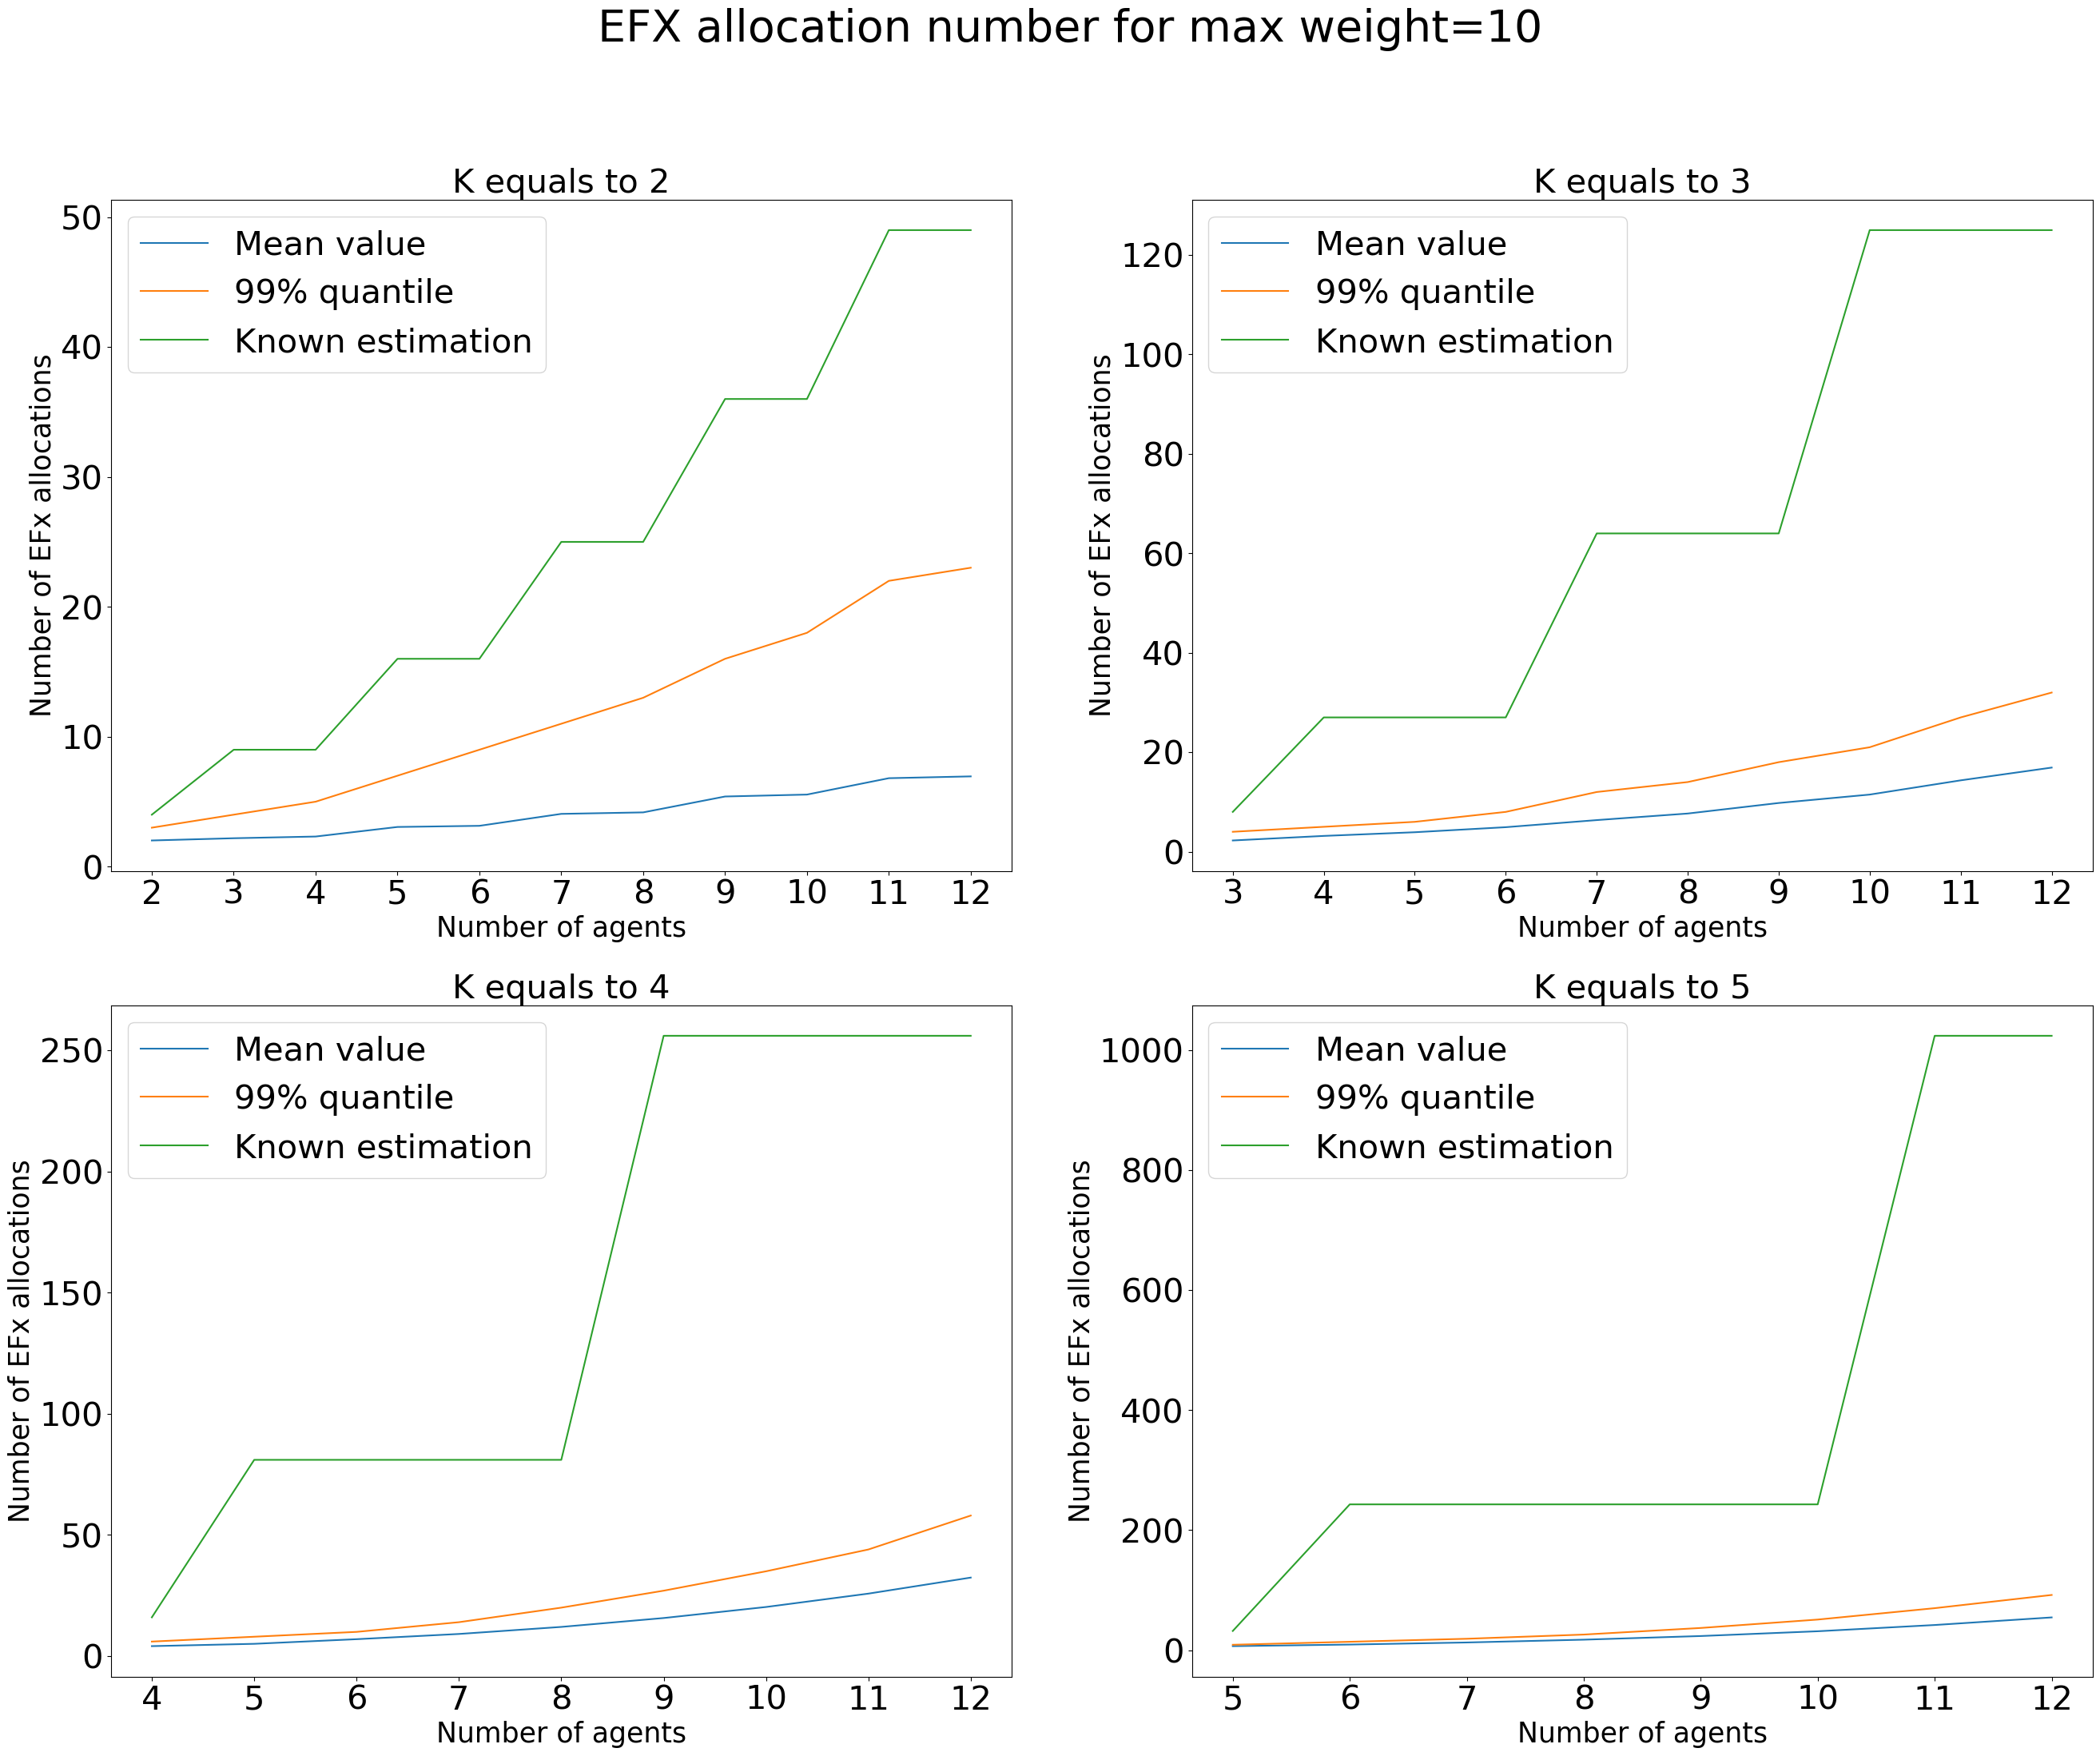

In [97]:
draw_solutions(sols_10_max, max_m=12, max_w=10)

In [48]:
sols_1000_max, times_1000_max = generate_solutions_sample_2_agents(max_m=12, num_exp=5000, max_w=1000, max_k=6)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [07:41<00:00, 35.46s/it]


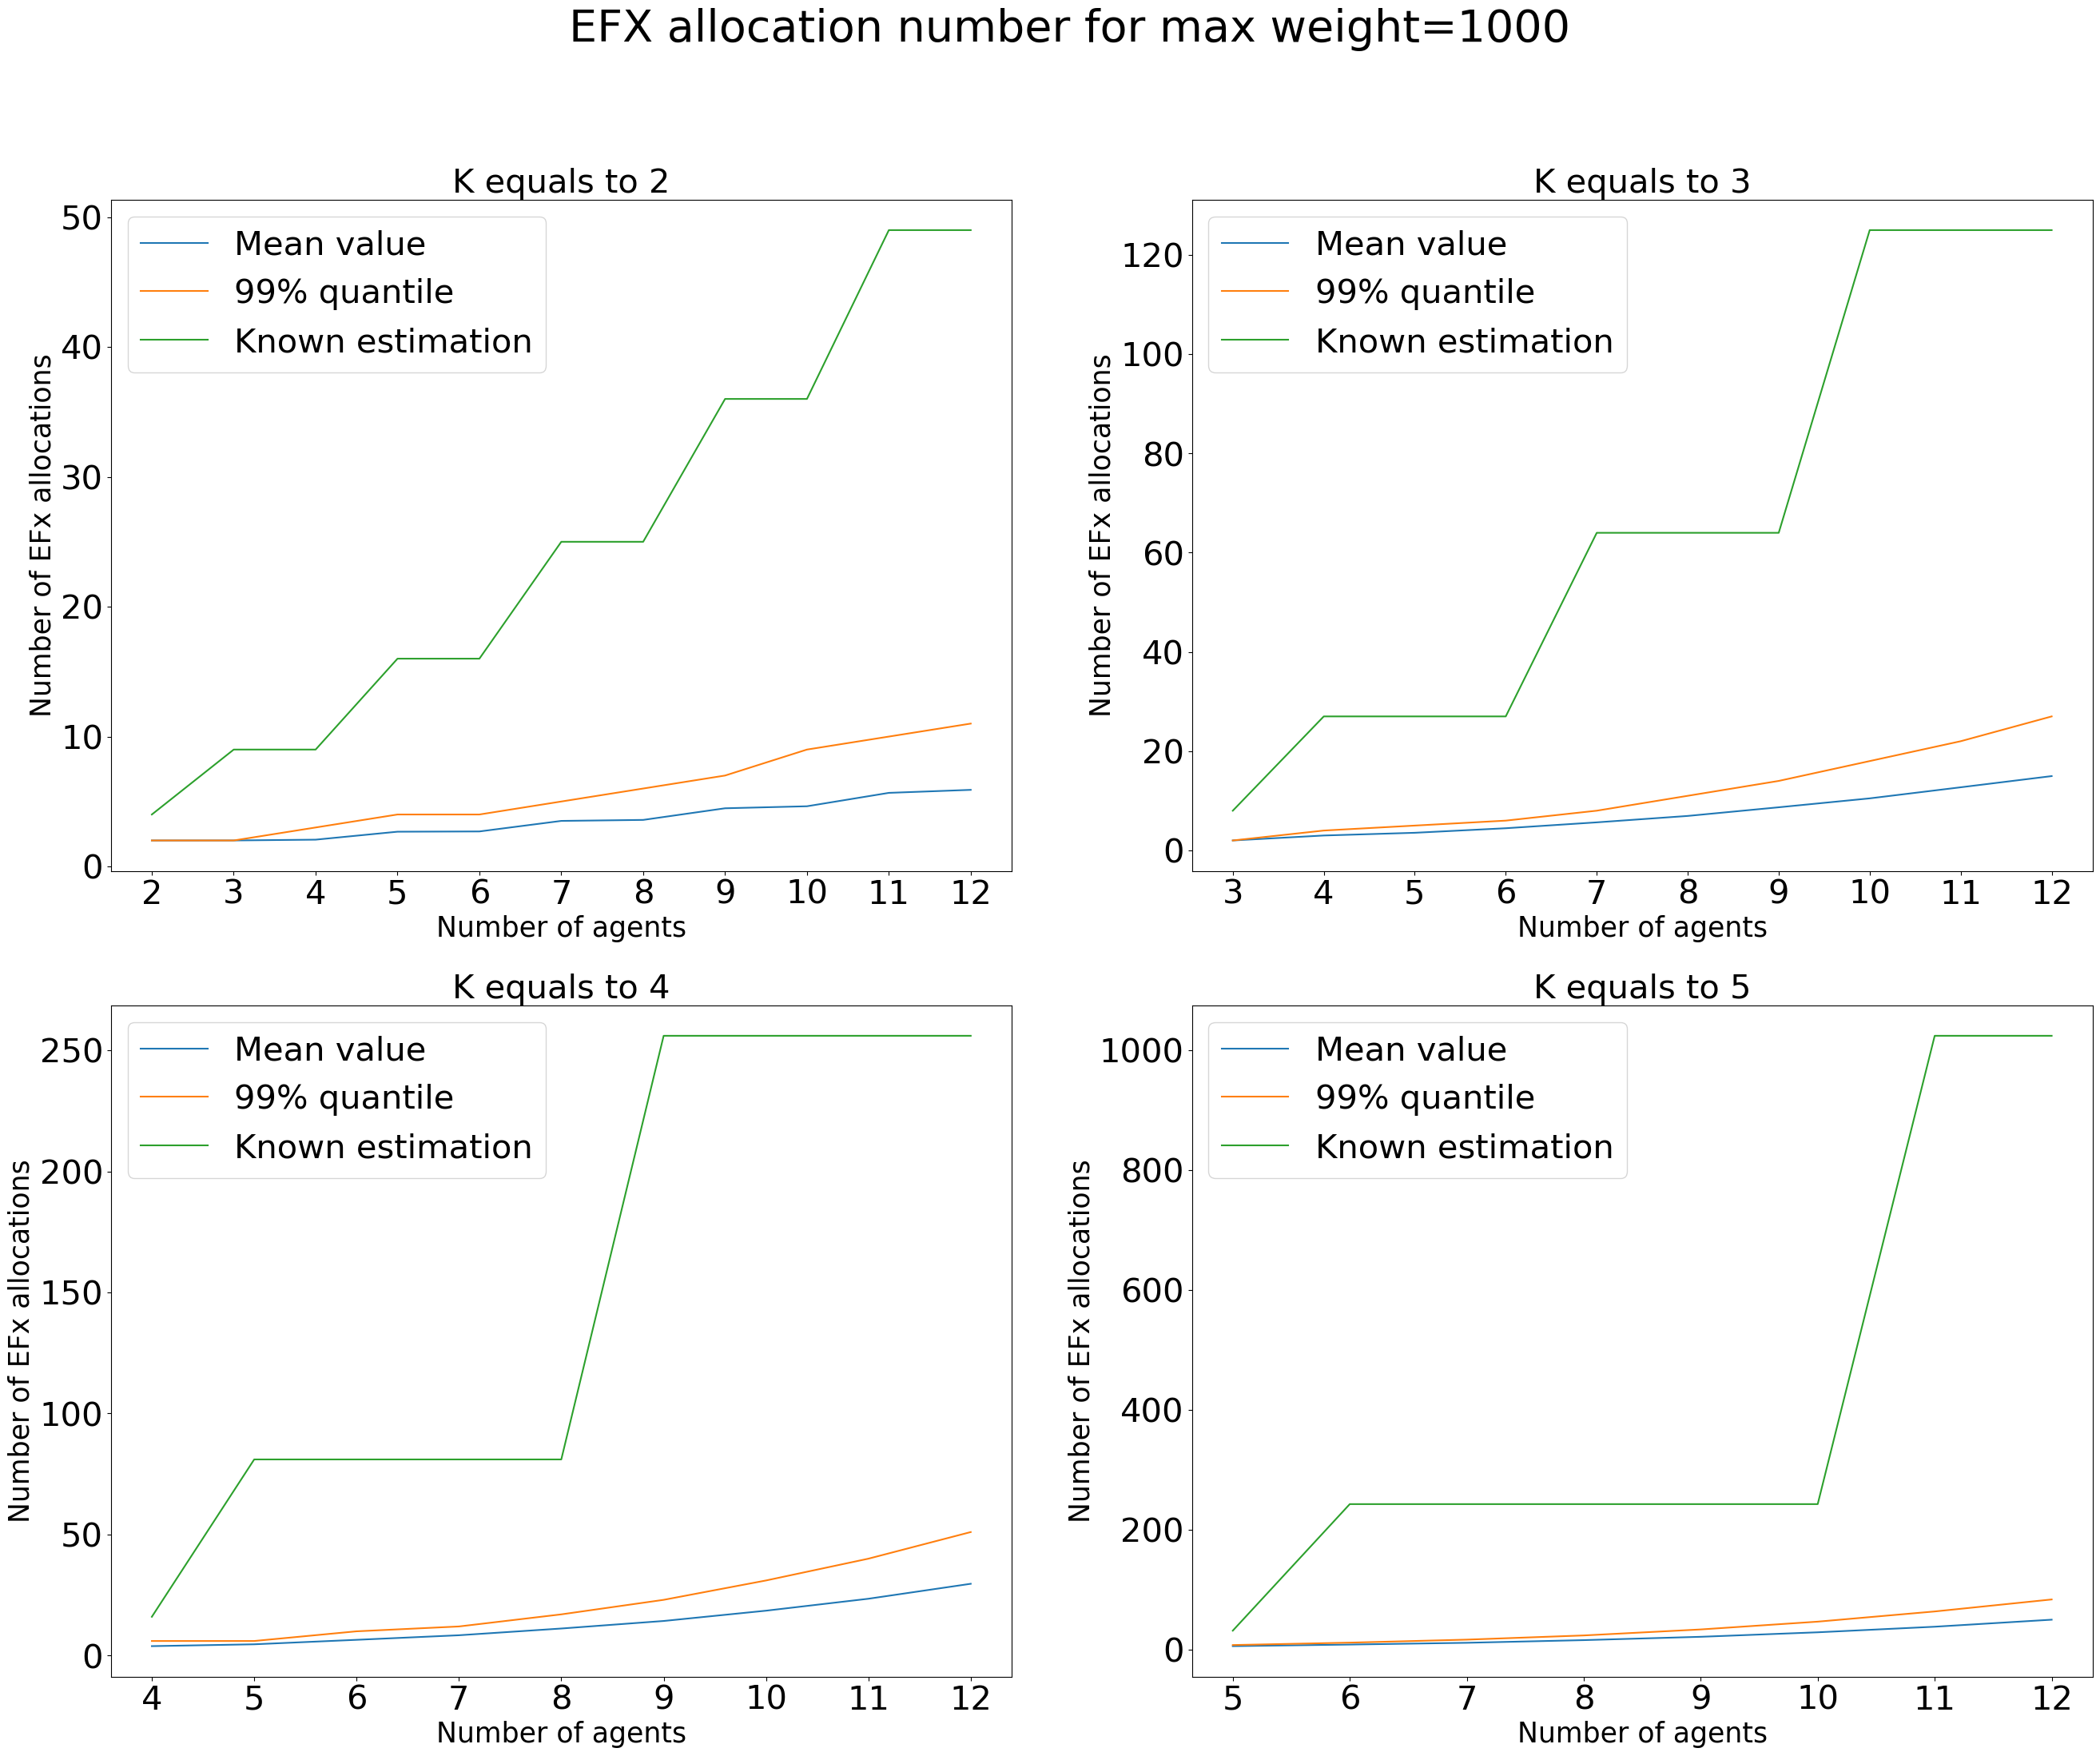

In [96]:
draw_solutions(sols_1000_max, max_m=12, max_w=1000)

In [99]:
time_avg = []

for i, arr in enumerate(times_10_max):
    time_avg.append([])
    for j, t in enumerate(arr):
        time_avg[i].append((t + times_1000_max[i][j]) / 2.0 )
time_avg

[[0.1845059156417847,
  0.3237693071365356,
  0.4319603443145752,
  0.5390031337738037,
  0.6886935949325561,
  0.866013765335083,
  1.0126449108123778,
  1.252976894378662,
  1.4783328771591187,
  1.8016345024108886,
  2.113065481185913],
 [0.44052081108093266,
  0.7021815299987793,
  1.0314021825790405,
  1.3723489046096802,
  1.9057863712310792,
  2.4425949811935426,
  3.042639207839966,
  3.7356673955917357,
  4.738994002342224,
  6.1056196928024296],
 [1.0803543090820313,
  1.6402356863021852,
  2.4658448696136475,
  3.445056891441345,
  4.722047591209412,
  6.2287372827529905,
  7.953815603256226,
  10.29872727394104,
  13.386198997497559],
 [2.3869613885879515,
  3.626412200927734,
  5.308823299407958,
  7.7546782970428465,
  10.954187822341918,
  15.229996681213379,
  20.261827397346497,
  27.110072994232176]]

In [137]:
def draw_diff(sols1, sols2, max_m, max_w1, max_w2):    
    sz = len(sols1)
    

    fig, axes = plt.subplots(int(sz / 2), 2)
    fig.set_figwidth(32)
    fig.set_figheight(24)
    fig.suptitle(f'Relative difference for weights={max_w1}, {max_w2}', fontsize=40)

    for i in range(sz):
        arr1 = np.array(sols1[i])
        arr2 = np.array(sols2[i])
        xind = int(i / 2)
        yind = i % 2

        #print([arr[j].mean() for j in range(10 - i - 2)])
        axes[xind, yind].plot(2 * (arr1.mean(axis=-1) - arr2.mean(axis=-1)) / (arr1.mean(axis=-1) + arr2.mean(axis=-1)))
        #print(arr1.mean() - arr2.mean())

        axes[xind, yind].set_xticks(list(range(max_m - 1 - i)))
        axes[xind, yind].set_xticklabels(list(range(i + 2, max_m + 1)))
        axes[xind, yind].set_title(f'K equals to {i + 2}', fontdict={"fontsize": 30})
        axes[xind, yind].tick_params(axis="both", labelsize=30)
        
        axes[xind, yind].set_xlabel("Number of agents", fontsize=25)
        axes[xind, yind].set_ylabel("Relative difference", fontsize=25)
        

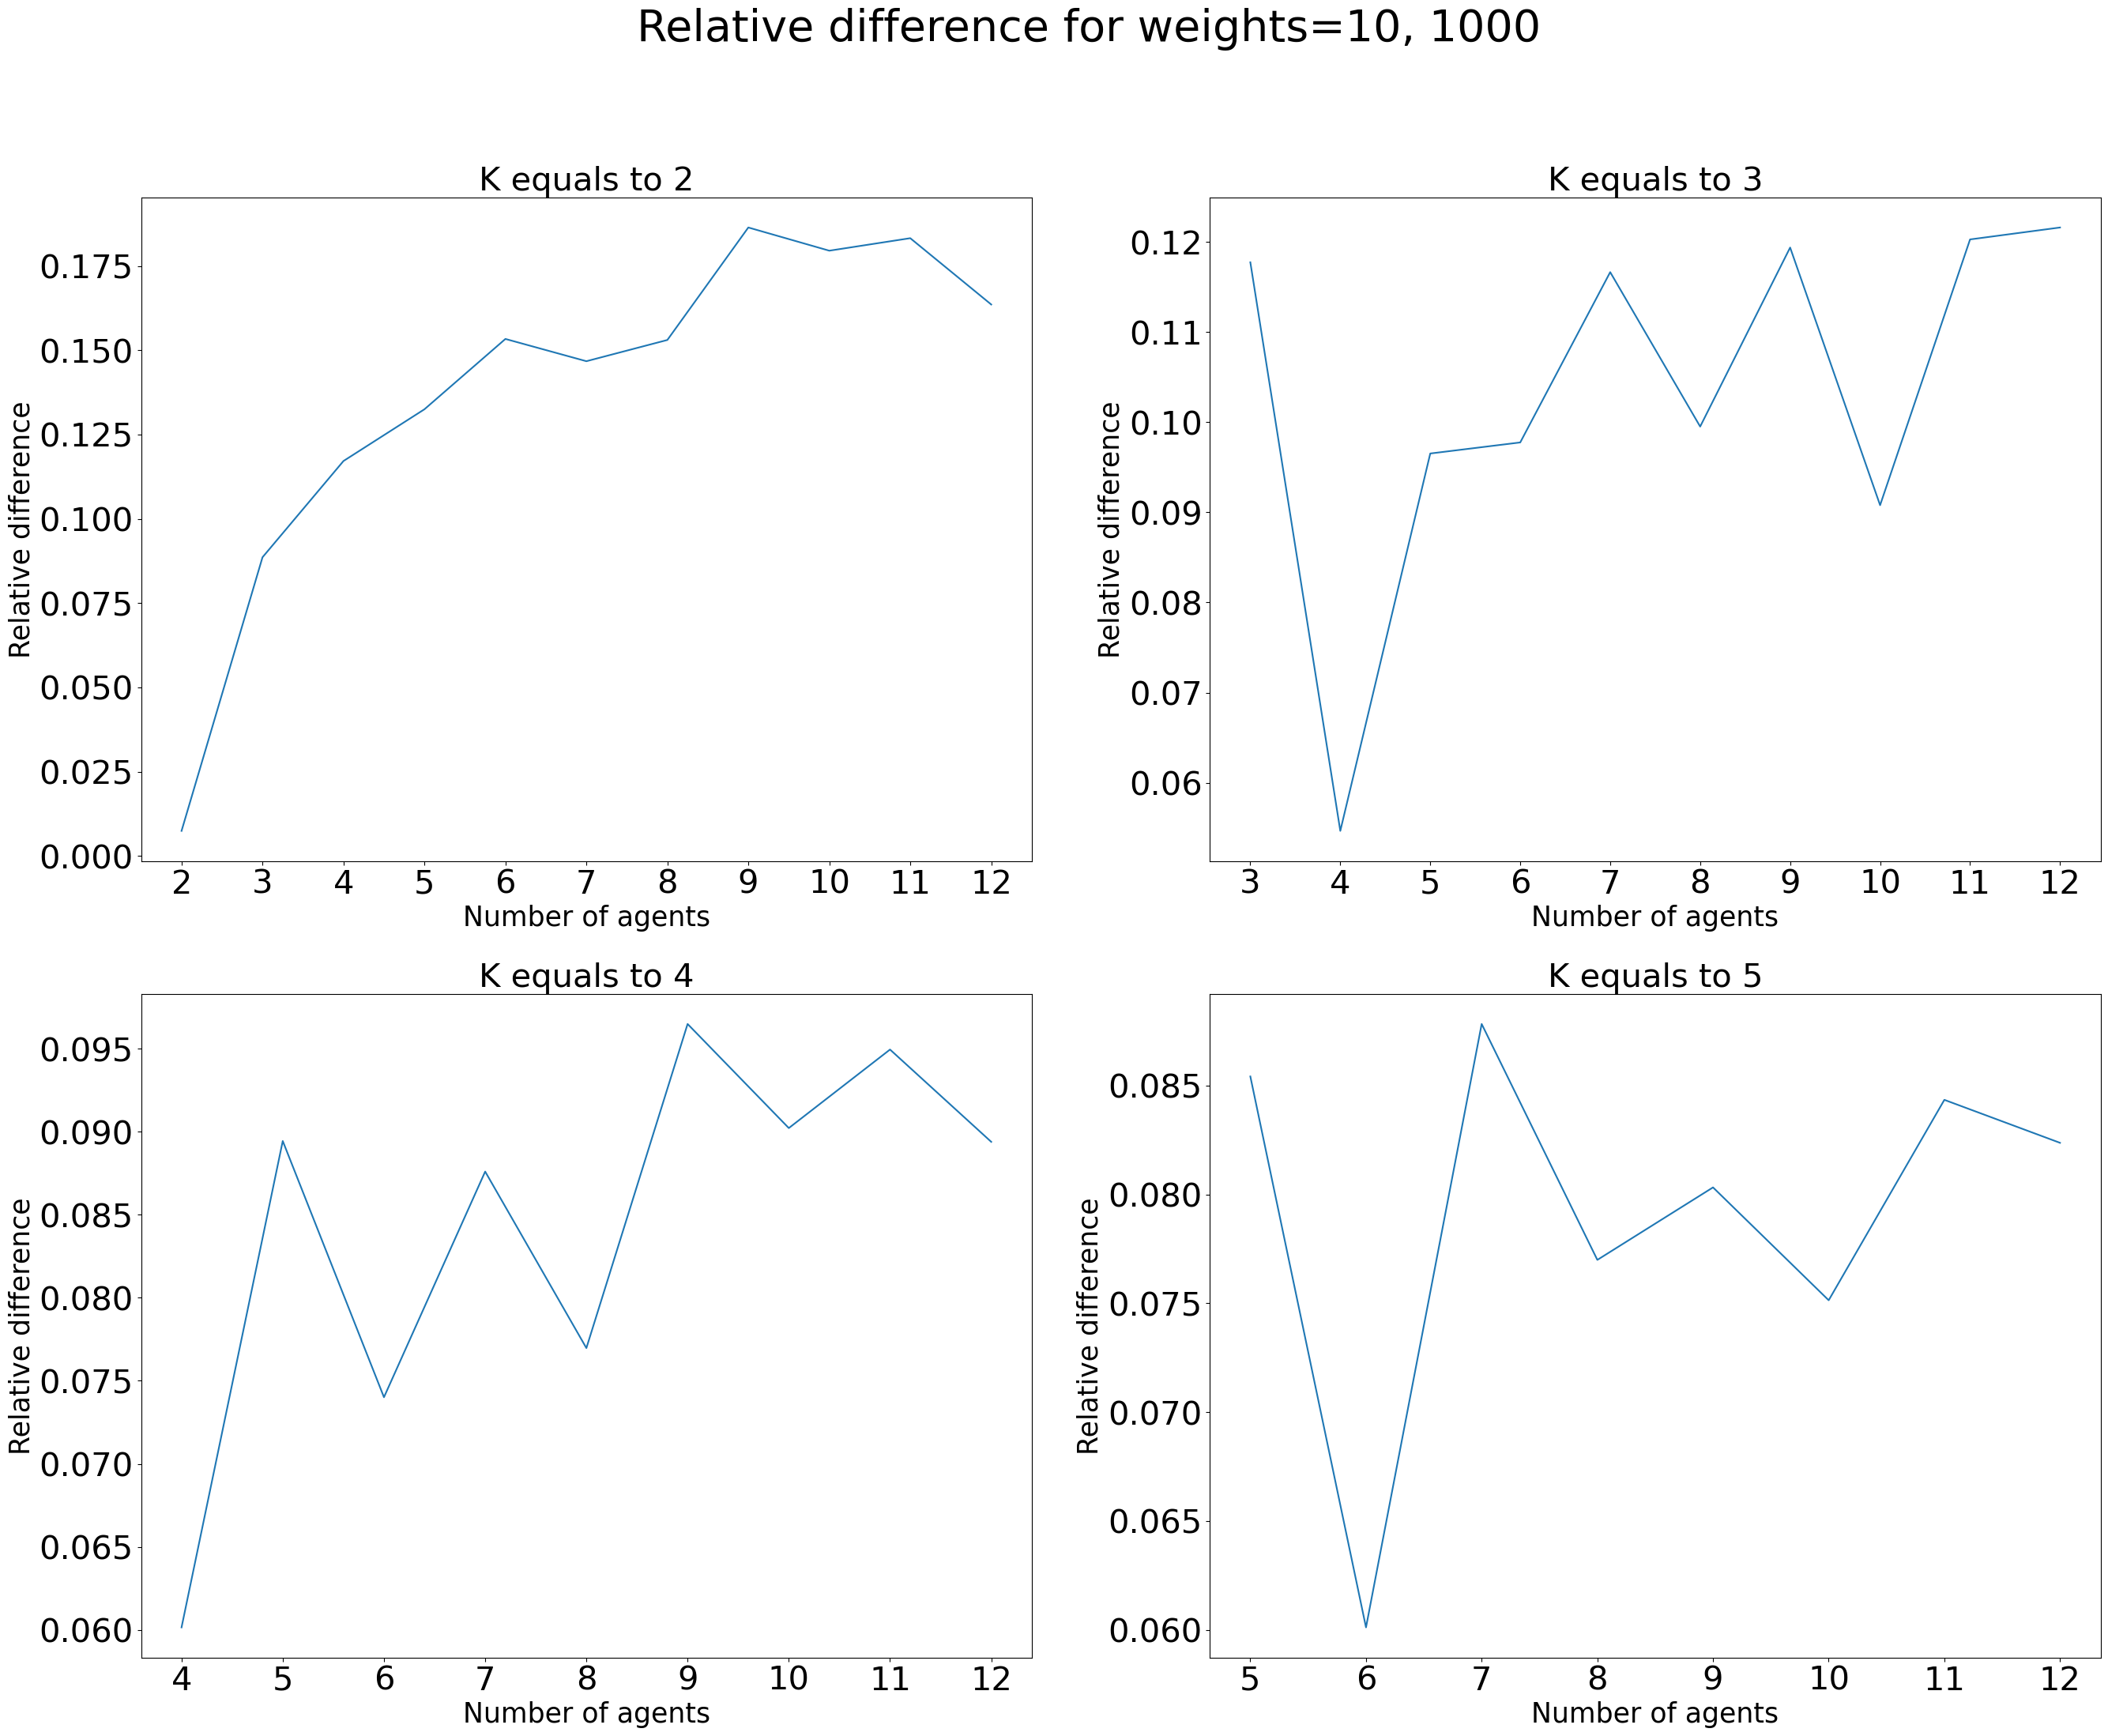

In [138]:
draw_diff(sols_10_max, sols_1000_max, 12, 10, 1000)

In [118]:
from scipy.stats import norm

def draw_normal(sols, m, k):
    numbers = sols[k - 2][m - k]
    plt.hist(numbers, density=True, bins=60)
    
    
    mu, std = norm.fit(numbers)
    
    
    xmin, xmax = plt.xlim()
    plt.title(f"Fit results: mu={mu:.2f}, std={std:.2f}")
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    
    
    
    

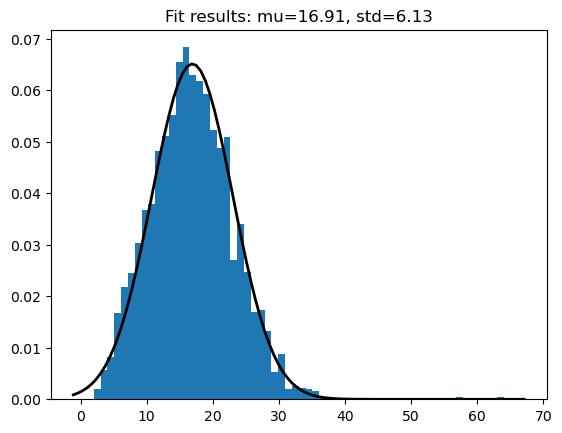

In [119]:
draw_normal(sols_10_max, 12, 3)

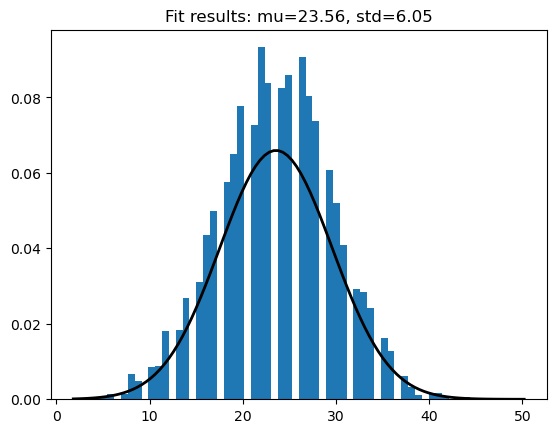

In [139]:
draw_normal(sols_10_max, 9, 5)

(array([  2.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,   0.,   2.,   0.,
          4.,   4.,   0.,   8.,  10.,   0.,   9.,  16.,   0.,  10.,   0.,
         17.,  17.,   0.,  16.,  27.,   0.,  33.,  28.,   0.,  29.,   0.,
         41.,  39.,   0.,  39.,  47.,   0.,  50.,  47.,   0.,  70.,   0.,
         58.,  72.,   0.,  81.,  74.,   0.,  90.,  80.,   0.,  87.,   0.,
         94.,  92.,   0., 106.,  94.,   0.,  96., 111.,   0.,  91.,   0.,
        109., 111.,   0., 132., 124.,   0., 114.,   0., 123., 122.,   0.,
        115., 108.,   0., 101., 139.,   0., 103.,   0., 113., 104.,   0.,
        114., 113.,   0., 101.,  90.,   0.,  86.,   0.,  91.,  94.,   0.,
         73.,  63.,   0.,  61.,  66.,   0.,  64.,   0.,  52.,  57.,   0.,
         44.,  45.,   0.,  40.,  37.,   0.,  25.,   0.,  31.,  34.,   0.,
         25.,  29.,   0.,  20.,  17.,   0.,  16.,   0.,  18.,  14.,   0.,
         10.,   9.,   0.,   5.,   0.,  10.,   7.,   0.,   6.,   2.,   0.,
          4.,   2.,   0.,   3.,   0., 

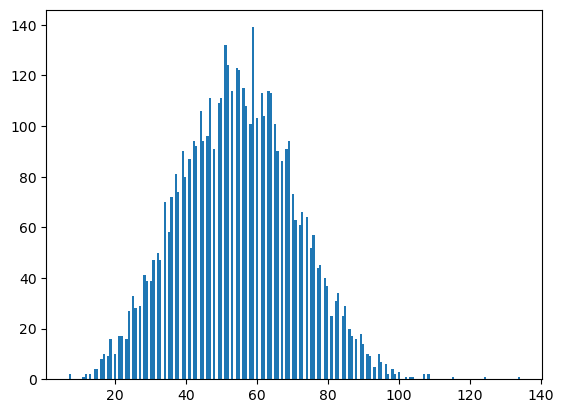

In [105]:
plt.hist(sols_10_max[3][7], bins=200)